In [16]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from IPython.display import Image
from langchain_core.messages import HumanMessage, AIMessage
from dotenv import load_dotenv
from typing import TypedDict

load_dotenv()

True

In [17]:
class AgentState(TypedDict):
    provider: str  # "openai" or "google"
    model: str  # e.g., "gpt-4" or "gemini-2.5-flash"
    temperature: float  # default at 0.0
    max_tokens: int  # default at 4096
    top_p: float  # default at 1.0
    parsed_docs: str
    summary: str
    messages: list[HumanMessage | AIMessage | str]  # Accepts list of HumanMessage, AIMessage, or str
    summary_type: str  # Few-shot / Map-Reduce / RAG / etc.
    llm: ChatOpenAI | ChatGoogleGenerativeAI  # LLM instance, supports LangChain chat models
    token_count: int  # Token count of the input documents
    summary_plan: str  # Plan for summarization approach

def initialize_agent_state(state) -> AgentState:
    if state.get("provider") == "openai":

        llm = ChatOpenAI(
            model=state.get("model", "gpt-4"),
            temperature=0.5,
        )
    else:
        llm = ChatGoogleGenerativeAI(
            model=state.get("model", "gemini-2.5-flash"),
            temperature=0.5,
            api_key=os.getenv("GOOGLE_API_KEY"),
        )
    state["llm"] = llm
    return state

# Step 1: Parse the PDF, could be from file upload
from PyPDF2 import PdfReader

def parse_pdf(state: AgentState) -> AgentState:
    # Dummy implementation, replace with actual PDF parsing logic
    sample_pdf_path = "../data/sample.pdf"  # Replace with actual PDF file path
    reader = PdfReader(sample_pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"
    state["parsed_docs"] = text or ""
    state["messages"].append(f"System: {state['parsed_docs']}")
    return state


# Count Tokens from the parsed_docs
def count_tokens(state: AgentState) -> AgentState:
    # Dummy implementation, replace with actual token counting logic
    parsed_docs = state.get("parsed_docs", "")
    token_count = len(parsed_docs) // 4  # Rough estimate: 1 token ~ 4 characters
    state["token_count"] = token_count
    return state

# Planner-Executor
# Read the parsed_docs and decide on the summarization strategy: Is novel topic, identify the difficult to understand sections and key points
def plan_summary(state: AgentState) -> str:
    planner_prompt = f"""Human:
    You are an award-winning editor specializing in summarizing technical documents for a broad audience. You are given a document enclosed in <document></document>. Your task is to create a strategy for summarizing this document. This strategy will serve as a set of instructions or prompts to guide other editors in producing the final summary.

    Specifically, you should:
    1. Provide a concise overview of the technical document.
    2. Identify sections that may be complex, technical, or challenging for readers.
    3. Suggest strategies or approaches for summarizing these difficult sections effectively.

    <document>{state["parsed_docs"]}</document>

    Assistant:"""

    llm = state["llm"]
    response = llm.invoke(planner_prompt.replace("<document></document>", state["parsed_docs"]))
    response_text = response.content if hasattr(response, 'content') else response
    state["summary_plan"] = response_text
    state["messages"].append(f"Planner: {response_text}")
    return state

def summarize(state: AgentState):
    llm = state["llm"]
    summarizer_prompt = f"""Human:
    You are an award-winning editor specializing in summarizing technical documents for a broad audience. You are given a document enclosed in <document></document> and a summarization strategy enclosed in <strategy></strategy>. Your task is to create a summary of the document based on the provided strategy.

    <document>{state["parsed_docs"]}</document>
    <strategy>{state["summary_plan"]}</strategy>

    Assistant:"""

    response = llm.invoke(summarizer_prompt)
    state["summary"] = response.content if hasattr(response, 'content') else response
    state["messages"].append(f"Summarizer: {response}")
    return state

In [18]:
workflow = StateGraph(AgentState)

workflow.set_entry_point("initialize")

workflow.add_node("initialize", initialize_agent_state)
workflow.add_node("parse_pdf", parse_pdf)
workflow.add_node("summarizer", summarize)
workflow.add_node("count_tokens", count_tokens)
workflow.add_node("plan_summary", plan_summary)


workflow.add_edge("initialize", "parse_pdf")  # first initialize the agent state
workflow.add_edge("parse_pdf", "count_tokens")  # after parsing, count tokens
workflow.add_conditional_edges(
    "count_tokens",
    lambda state: "plan_summary" if state["token_count"] > 3000 else "end",
    {
        "plan_summary": "plan_summary",
        "end": END,
    },
)
workflow.add_edge("plan_summary", "summarizer")  # after planning, summarize
workflow.add_edge("summarizer", END)


In [19]:
app = workflow.compile()

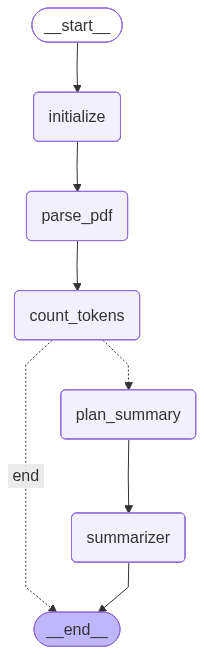

In [20]:
Image(app.get_graph().draw_mermaid_png())

In [21]:
def run_workflow(workflow, initial_input=None):
    app = workflow.compile()
    initial_state = initial_input or {"messages": [HumanMessage(content="Start workflow")]}
    return app.invoke(initial_state)

output = run_workflow(workflow)

E0000 00:00:1758958096.491028 49318028 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [23]:
print(output["summary_plan"])

Here's a strategy for summarizing the "Attention Is All You Need" document for a broad audience:

---

### Summarization Strategy: "Attention Is All You Need"

**1. Concise Overview of the Technical Document:**

The core message of this paper is the introduction of a revolutionary neural network architecture called the **Transformer**. Unlike previous dominant models that relied on sequential processing (Recurrent Neural Networks, RNNs) or local processing (Convolutional Neural Networks, CNNs), the Transformer is built **entirely on "attention mechanisms."** This novel approach allows the model to process all parts of an input sequence simultaneously, leading to several key advantages:

*   **Faster Training:** Significantly more parallelizable, meaning it can be trained much quicker (e.g., in hours/days rather than weeks).
*   **Superior Performance:** Achieves state-of-the-art results in machine translation tasks, outperforming even complex ensemble models.
*   **Better Long-Range Un